# Обучение модели классификатора 

In [62]:
import os

from ultralytics import YOLO
import cv2
from PIL import Image
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils import visualize_ba, visualize_distribution

ModuleNotFoundError: No module named 'sklearn'

## Загрузка датасета

In [2]:
train_df = pd.read_excel(r'train/train.xlsx')
train_df["id"] = train_df["ID"].apply(
    lambda filename: int(filename.replace("image_", "").split(".")[0])
)
train_df.drop(
    columns=[
        "Unnamed: 0.1",
        "Unnamed: 0",
        "ID",
        'annotation_path_label',
    ],
    inplace=True,
)
train_df.index = train_df["id"]

print(f'Количество исследований: {len(train_df)}')
train_df.head()

Количество исследований: 384


,image_path,pathology,id
id,,,
393,train/images/image_393.jpg,1,393
326,train/images/image_326.jpg,1,326
290,train/images/image_290.jpg,1,290
206,train/images/image_206.jpg,1,206
429,train/images/image_429.jpg,0,429


## Обрезка, сохранение новых изображений с помощью YOLO

In [3]:
model = YOLO(model='./models/best.pt')

result_list = []
count = 0
os.makedirs('train_classification/img', exist_ok=True)

for idx in train_df.index:
    try:
# for idx in [206]:
        result_bbox = model(train_df.loc[idx]['image_path'])
        for r in result_bbox:
                x = int(list(r.boxes.cuda().xywh)[0][0])
                y = int(list(r.boxes.cuda().xywh)[0][1])
                w = int(list(r.boxes.cuda().xywh)[0][2])
                h = int(list(r.boxes.cuda().xywh)[0][3])
                # Обрезаем изображение и сохраняем
                image = cv2.imread(train_df.loc[idx]['image_path'])
                crop_image = image[y:y+h, x:x+w]
                image_path = 'train_classification/img' + train_df.loc[idx]['image_path'][-14:]
                cv2.imwrite(image_path, crop_image)
                
                result_list.append([train_df.loc[idx]['id'], image_path, train_df.loc[idx]['pathology']])
    except:
        count += 1
            
print(f"{count} изображений, где не найден bbox")



image 1/1 /home/gordeevae/spina_bifida/train/images/image_393.jpg: 640x256 1 ROI, 19.1ms
Speed: 1.1ms preprocess, 19.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

image 1/1 /home/gordeevae/spina_bifida/train/images/image_326.jpg: 640x256 1 ROI, 13.1ms
Speed: 1.3ms preprocess, 13.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 256)

image 1/1 /home/gordeevae/spina_bifida/train/images/image_290.jpg: 640x224 1 ROI, 19.8ms
Speed: 1.1ms preprocess, 19.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 224)

image 1/1 /home/gordeevae/spina_bifida/train/images/image_206.jpg: 640x288 1 ROI, 19.8ms
Speed: 1.3ms preprocess, 19.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 288)



/home/gordeevae/spina_bifida/venv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


image 1/1 /home/gordeevae/spina_bifida/train/images/image_429.jpg: 640x320 2 ROIs, 19.8ms
Speed: 1.4ms preprocess, 19.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /home/gordeevae/spina_bifida/train/images/image_252.jpg: 640x384 1 ROI, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /home/gordeevae/spina_bifida/train/images/image_435.jpg: 640x288 (no detections), 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /home/gordeevae/spina_bifida/train/images/image_542.jpg: 640x448 1 ROI, 19.4ms
Speed: 1.8ms preprocess, 19.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/gordeevae/spina_bifida/train/images/image_316.jpg: 640x320 1 ROI, 15.0ms
Speed: 1.4ms preprocess, 15.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /home/gordeevae/spina_bifida/train/images/im

In [4]:
# Формирование новой таблицы с путями
classification_train_df = pd.DataFrame(result_list)
classification_train_df = classification_train_df.rename(columns={0: 'id',
                                        1: 'img_path',
                                        2: 'class'})
classification_train_df.index = classification_train_df["id"]
print(f'Количество исследований: {len(classification_train_df)}')
classification_train_df.head()

Количество исследований: 336


,id,img_path,class
id,,,
393,393,train_classification/img/image_393.jpg,1
326,326,train_classification/img/image_326.jpg,1
290,290,train_classification/img/image_290.jpg,1
206,206,train_classification/img/image_206.jpg,1
429,429,train_classification/img/image_429.jpg,0


## Балансировка датасета

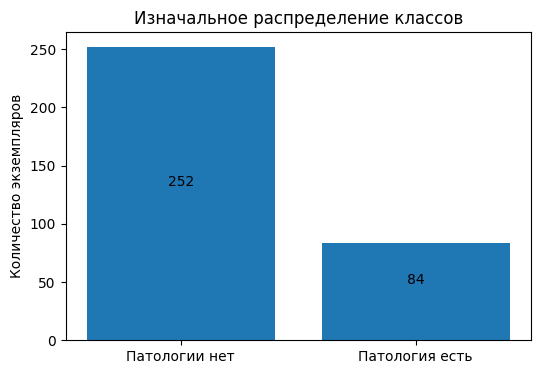

In [5]:
visualize_distribution(classification_train_df)

In [6]:
# Разделение на классы
class_0 = classification_train_df[classification_train_df['class'] == 0]
class_1 = classification_train_df[classification_train_df['class'] == 1]

# Определение большего и меньшего классов
if len(class_0) > len(class_1):
    majority_class = class_0
    minority_class = class_1
else:
    majority_class = class_1
    minority_class = class_0

In [7]:
# Целевое количество сэмплов (среднее между классами)
target_samples = int((len(majority_class) + len(minority_class)) / 2)
print(f'Целевое количество сэмплов: {target_samples}')

Целевое количество сэмплов: 168


In [8]:
# Undersampling большего класса
majority_downsampled = majority_class.sample(n=target_samples, random_state=42)

print(f'Размер после урезания большего класса: {len(majority_downsampled)}')

# Oversampling меньшего класса
minority_oversampled = minority_class.sample(replace=True, n=target_samples, random_state=14)
duplicates = minority_oversampled[minority_oversampled.duplicated()]

print(f'Размер после урезания большего класса {len(majority_downsampled)}\n',
      f'Количество дубликатов: {len(duplicates)}')

# Склейка массивов двух классов
balanced_dataset = pd.concat([minority_oversampled, majority_downsampled])
classification_train_df = balanced_dataset

Размер после урезания большего класса: 168
Размер после урезания большего класса 168
 Количество дубликатов: 98


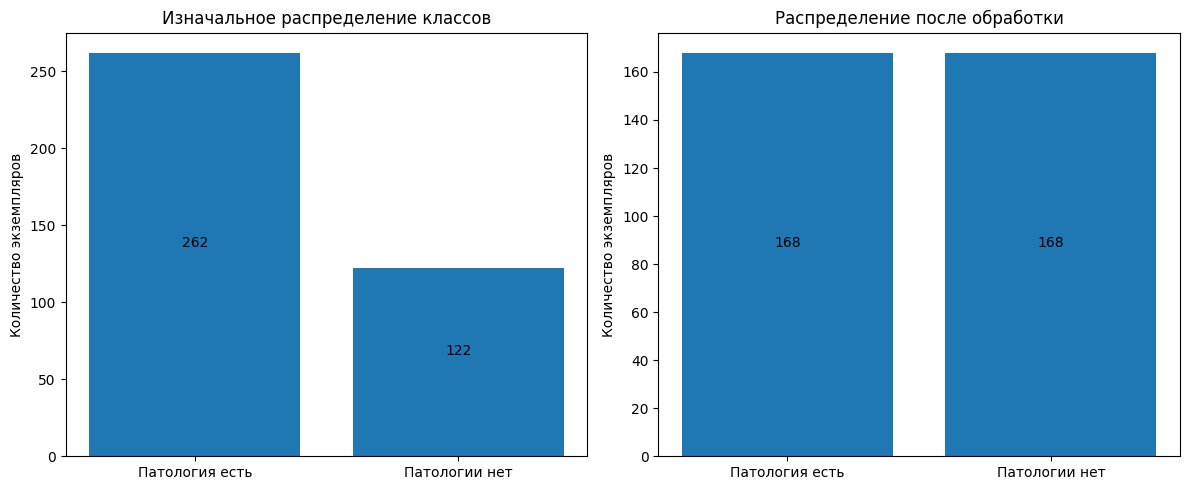

In [9]:
visualize_ba(train_df, balanced_dataset)

In [10]:
classification_train_df

,id,img_path,class
id,,,
579,579,train_classification/img/image_579.jpg,0
440,440,train_classification/img/image_440.jpg,0
538,538,train_classification/img/image_538.jpg,0
496,496,train_classification/img/image_496.jpg,0
507,507,train_classification/img/image_507.jpg,0
...,...,...,...
408,408,train_classification/img/image_408.jpg,1
270,270,train_classification/img/image_270.jpg,1
149,149,train_classification/img/image_149.jpg,1


## Инициализация класса датасета, модели и обучение

In [34]:
class SpinaBifidaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['class']

        if self.transform:
            image = self.transform(image)

        return image, label


In [51]:
import numpy as np

train, validate, test = \
              np.split(classification_train_df.sample(frac=1, random_state=42), 
                       [int(.6*len(classification_train_df)), int(.8*len(classification_train_df))])

In [52]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
# Создание датасетов
train_dataset = SpinaBifidaDataset(train, transform=transform)
validate_dataset = SpinaBifidaDataset(validate, transform=transform)
test_dataset = SpinaBifidaDataset(test, transform=transform)

# Создание DataLoader'ов
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(validate, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [59]:
# Загрузка предобученной модели DenseNet
model = models.densenet121(pretrained=True)

# Замена последнего слоя для двух классов
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 2)

# Перемещение модели на GPU, если доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break
    
    model.load_state_dict(best_model)
    return model

In [61]:
model = train_model(model, train_loader, val_loader, criterion, optimizer)

NameError: name 'ReduceLROnPlateau' is not defined